# Spaced Repetition Algorithim

## Ebbinghaus
The ebbinghaus model will represent human memory decay. See the paper for more details.


$$
p=2^{-\frac{\Delta}{h}}\\
\Delta = \text{time since last review}\\
h = \text{half life (memory decay constant)}\\
p = \text{probability of recall}\\
$$

This model will be used to retroactively evaluate algorithims to see how they would perform on historical data. See the evaluation section to see how we define "performance". Here are a couple of derivations that are important from this function:

#### Solving For Half Life
For a given sample, under the current models assumption, given an empirical probability, and $\Delta$, we can solve for the half life.
$$
p=2^{-\frac{\Delta}{h}}\\
\log_2 p=-\frac{\Delta}{h}\\
h = -\frac{\Delta}{\log_2 p}
$$

## Dataset
The dataset we will be using to retroactively evaluate our algorithims will be from DuoLingo's user logs. This contains a log of user test sessions: time since last test, a number of user features (see dataset), and the proportion of questions correct for that session. 

## Evaluation
To evaluate each algorithim, we must estimate the half life for the user based on all the user features.

$$
h_\Theta = f(\mathbf{x})\\
\mathbf{x} = \text{user features}
$$

Here $\Theta$ is set of optimal weights that correspond to each user feature. Howevever spaced repitition algorithims have a problem where they only output Intervals as opposed to half lifes. So to retroactively evaluate algorithims that are heuristic based, we can instead output the interval and convert it to a half life based on the Ebbinghaus equations.

$$
h = -\frac{I_a}{\log_2 p_a}
$$

Here $I_a$ is the interval outputed from algorithim $a$.  $p_a$ is the target probability for the algorithim, or the recall probability at which it reccommends a review. This presents another problem. The heuristic based algorithims are not directly modeled via Ebbinghaus, so there is no $p_a$ explicitly stated in the implementation. There is also a lot of different school of though on what the best $p_a$ is for optimal review. For our purpose, we just want to compare how these algorithims would **rank** items for review as opposed to their predicited recall. So for now we assume $p_a$ as a consistent probability (0.5), and intead compute error based on the Wilcox Rank Sum metric. This will look at the error in ordinality from the empirical half life and from the half life derived from recccommended interval.


## Evaluation
To evaluate each algorithim, we will be using historical data to try and estimate a theoretical half life. However most algorithims always reccommend delta, or the interval at which the next review session should be held. The paper makes an assumption that all algorithims must initiate a review session at $p=0.5$. In this evaluation, we will compare performance across multiple values of $p$.\
\
$\mathcal{D} = \{\langle p, \Delta, \mathbf{x}\rangle\}^D_i \quad$ This represents the dataset we have\
\
We will calculate a loss function using the observed recall and a theoretical recall. The theoretical recall is computed via $\Delta$ and $h_\Theta$. $h_\Theta$ is a function that takes a set of input features and estimates a half life. 

In [1]:
import numpy as np
import pandas as pd
import torch
from data import DuoLingo
import matplotlib.pyplot as plt

In [29]:
dataset = DuoLingo()
dataset[0]

{'delta': 320.0189236111111,
 'p': 1.0,
 'correct': 4,
 'incorrect': 2,
 'hist_p': array([ 0.6666667, -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1

In [30]:
ui_map = dataset.user_item_ctx

user_item_sample = None

for key in ui_map:
    for item in ui_map[key]:
        if len(ui_map[key][item]) > 10:
            cnt = 0
            for p in dataset[ui_map[key][item]]['p']:
                if p != 1 and p != 0 and p!=.5:
                    cnt += 1
            if cnt > 3:
                user_item_sample = ui_map[key][item]
                break
print(dataset[user_item_sample])

{'delta': array([27.43917824074074, 0.005300925925925926, 0.0037731481481481483,
       0.0029745370370370373, 0.0034027777777777776, 0.004768518518518518,
       0.005, 0.0016550925925925926, 0.0021064814814814813,
       0.0017939814814814815, 0.0016087962962962963, 0.001875,
       0.0019212962962962964, 0.0032407407407407406], dtype=object), 'p': array([1.0, 0.857142857143, 0.875, 0.625, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0], dtype=object), 'correct': array([3, 7, 13, 20, 25, 34, 41, 45, 48, 52, 56, 58, 62, 65], dtype=object), 'incorrect': array([1, 1, 2, 3, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7], dtype=object), 'hist_p': array([[ 0.75      , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.75      ,  1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.75      ,  1.        ,  0.85714287, ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 0.75      ,  1.        ,  0.85714

In [32]:
user_item_sample = dataset[user_item_sample]

0.857142757143
0.005300925925925926
0.023835892797746835

0.8749999
0.0037731481481481483
0.019585991810021585

0.6249999
0.0029745370370370373
0.004386756038716357

0.9999999
0.0034027777777777776
23586.25706048886

0.8749999
0.004768518518518518
0.02475284854518065

0.9999999
0.005
34657.357313371394

0.9999999
0.0016550925925925926
11472.22707363914

0.9999999
0.0021064814814814813
14601.016275540724

0.9999999
0.0017939814814814815
12434.931443455012

0.9999999
0.0016087962962962963
11151.32561703385

0.9999999
0.001875
12996.508992514271

0.9999999
0.0019212962962962964
13317.410449119563

0.9999999
0.0032407407407407406
22463.101962370343



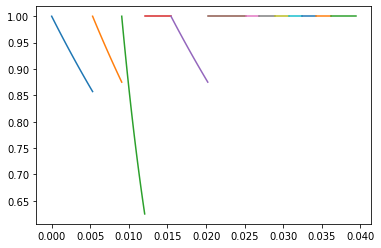

In [35]:
import math
x = []

x_last = 0
for i in range(len(user_item_sample['p'])):
    if i== 0:
        continue
    p = max(user_item_sample['p'][i] - 1e-7,0)
    
    delta = user_item_sample['delta'][i]
    h = -(delta) / (math.log2(p))
    x = np.linspace(x_last,x_last+delta,100)
    print(p)
    print(delta)
    print(h)
    print()
    y = 2**(-(x-x_last)/h)
    x_last = x_last+delta
    plt.plot(x,y)
    
plt.show()

[[1.0 1362076081 27649635 ... 4 2 2]
 [0.5 1362076081 27649635 ... 4 2 1]
 [1.0 1362076081 27649635 ... 4 1 1]
 ...
 [1.0 1363104897 368 ... 4 4 4]
 [0.6 1363104897 368 ... 2 5 3]
 [0.666666666667 1363104897 368 ... 3 9 6]]


{'76390c1350a8dac31186187e2fe1e178': [0, 8, 51, 57, 59],
 '7dfd7086f3671685e2cf1c1da72796d7': [1, 9, 52],
 '35a54c25a2cda8127343f6a82e6f6b7d': [2, 10, 17, 61],
 '0cf63ffe3dda158bc3dbd55682b355ae': [3, 11, 55],
 '84920990d78044db53c1b012f5bf9ab5': [4, 12, 16, 63],
 '56429751fdaedb6e491f4795c770f5a4': [5, 13, 62],
 '1bacf218eaaf9f944e525f7be9b31899': [6, 14, 60],
 '4fcb6bb8e44d7b618999721071862827': [18],
 'a6834806c43ea1be9eb3e4fdae6f98db': [19],
 'dd34978165d17f7e729a2ef331a7600d': [53, 58],
 '495f763ef6027e020c53431484aa5ede': [54],
 '46b112cd07fdcc98db8670a5d71c613d': [56]}